# Test Delight Learn 

- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNRS
- creation date : June  18th 2021

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import sys
sys.path.append('../')
from delight.io import *
from delight.utils import *
from delight.photoz_gp import PhotozGP

In [2]:
from matplotlib.colors import LogNorm

In [3]:
from mpi4py import MPI
from delight.photoz_kernels import Photoz_mean_function, Photoz_kernel

In [4]:
logger = logging.getLogger(__name__)
coloredlogs.install(level='DEBUG', logger=logger,fmt='%(asctime)s,%(msecs)03d %(programname)s, %(name)s[%(process)d] %(levelname)s %(message)s')

In [5]:
plt.rcParams["figure.figsize"] = (6,4)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

# Configuration

- select if want to control Delight internal simulation or DC2

In [6]:
FLAG_DC2=True

In [7]:
if FLAG_DC2:
    configfilename='tmp/parametersTest.cfg'
    flux_multiplicative_factor=1.
    flux_multiplicative_factor2=1.
    flux_multiplicative_factor=0.45e-10 # factor such if it multiplies data flux in sim gives true data flux
    flux_multiplicative_factor2=0.45e-4 # factor such if it is multiplied to models it gives true data flux level
else:
    configfilename='tmpsim/parametersTest.cfg'
    flux_multiplicative_factor=0.45e-10 # factor such if it multiplies data flux in sim gives true data flux
    flux_multiplicative_factor2=0.45e-4 # factor such if it is multiplied to models it gives true data flux level

# Load config and data

In [8]:
params = parseParamFile(configfilename, verbose=False)


comm = MPI.COMM_WORLD
threadNum = comm.Get_rank()
numThreads = comm.Get_size()


if threadNum == 0:
    logger.info("--- DELIGHT-LEARN ---")


2021-06-18 21:56:38,901 ipykernel_launcher.py, __main__[285] INFO --- DELIGHT-LEARN ---


In [9]:
# Read filter coefficients, compute normalization of filters
bandCoefAmplitudes, bandCoefPositions, bandCoefWidths, norms = readBandCoefficients(params)
numBands = bandCoefAmplitudes.shape[0]

redshiftDistGrid, redshiftGrid, redshiftGridGP = createGrids(params)

f_mod = readSEDs(params)

In [10]:
numBands

6

In [11]:
all_renormmodel=[]
all_fluxes=[]

# Learn

In [12]:
numObjectsTraining = np.sum(1 for line in open(params['training_catFile']))

msg= 'Number of Training Objects ' + str(numObjectsTraining)
logger.info(msg)


firstLine = int(threadNum * numObjectsTraining / numThreads)
lastLine = int(min(numObjectsTraining,(threadNum + 1) * numObjectsTraining / numThreads))
numLines = lastLine - firstLine

    
msg ='Thread ' +  str(threadNum) + ' , analyzes lines ' + str(firstLine) + ' , to ' + str(lastLine)
logger.info(msg)

DL = approx_DL()


<ipython-input-12-436ba5cc070e>:1: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  numObjectsTraining = np.sum(1 for line in open(params['training_catFile']))
2021-06-18 21:56:39,139 ipykernel_launcher.py, __main__[285] INFO Number of Training Objects 3755
2021-06-18 21:56:39,141 ipykernel_launcher.py, __main__[285] INFO Thread 0 , analyzes lines 0 , to 3755


In [13]:
f_mod.shape

(8, 6)

In [14]:
gp = PhotozGP(f_mod, bandCoefAmplitudes, bandCoefPositions, bandCoefWidths,
              params['lines_pos'], params['lines_width'],
              params['V_C'], params['V_L'],
              params['alpha_C'], params['alpha_L'],
              redshiftGridGP, use_interpolators=True)

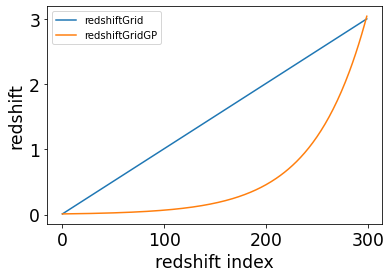

In [15]:
plt.plot(redshiftGrid,label="redshiftGrid")
plt.plot(redshiftGridGP,label="redshiftGridGP")
plt.xlabel("redshift index")
plt.ylabel("redshift")
plt.legend()

In [16]:
gp.mean_fct?

Type:           Photoz_linear_sed_basis
String form:    <delight.photoz_kernels.Photoz_linear_sed_basis object at 0x7f6c1d7789d0>
File:           ~/.local/lib/python3.8/site-packages/delight/photoz_kernels.py
Docstring:     
Mean function of photoz GP, based on a library of templates.

Args:
    f_mod_interp: grid of interpolators of size (num templates, num bands)
        called as ``f_mod_interp[it, ib](z)``
Init docstring: Constructor.


In [17]:
X=np.zeros((numBands,3))
X[:,0]=np.arange(numBands)
X[:,1]=1.5
X[:,2]=1.0

In [18]:
gp.mean_fct.f(X).shape

(6, 8)

In [19]:
all_F=[]
all_z=[]
for z in np.linspace(0.1,3,50):
    X=np.zeros((numBands,3))
    X[:,0]=np.arange(numBands)
    X[:,1]=z
    X[:,2]=1.0
    Fluxes=gp.mean_fct.f(X)
    all_F.append(Fluxes)
    all_z.append(z)
    

In [20]:
ib=1
it=0
F= [ f[ib,it] for f in all_F ]

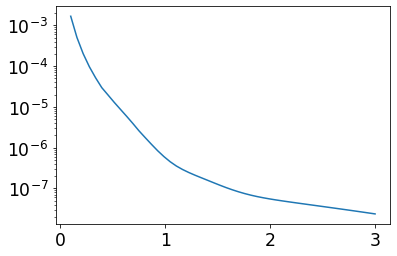

In [21]:
plt.plot(all_z,F)
plt.yscale("log")

In [22]:
gp.kernel?

Type:           Photoz_kernel
String form:    <delight.photoz_kernels.Photoz_kernel object at 0x7f6c1d778a90>
File:           ~/.local/lib/python3.8/site-packages/delight/photoz_kernels.py
Docstring:     
Photoz kernel based on RBF kernel in SED space.

Args:
    fcoefs_amp: ``numpy.array`` of size (numBands, numCoefs)
        describint the amplitudes of the Gaussians approximating the
        photometric filters.
    fcoefs_mu: ``numpy.array`` of size (numBands, numCoefs)
        describint the positions of the Gaussians approximating the
        photometric filters.
    fcoefs_sig: ``numpy.array`` of size (numBands, numCoefs)
        describint the widths of the Gaussians approximating the
        photometric filters.
    lines_mu: ``numpy.array`` of SED line positions
    lines_sig: ``numpy.array`` of SED line widths
    var_C: GP variance for SED continuum correlations.
        Should be a ``float`, preferably between 1e-3 and 1e2.
    var_L: GP variance for SED line correlations.

In [23]:
gp.kernel.g_AB

1.0

In [24]:
X1=np.zeros((numBands,3))
X1[:,0]=np.arange(numBands)
X1[:,1]=1
X1[:,2]=1.0

In [25]:
X2=np.zeros((numBands,3))
X2[:,0]=np.arange(numBands)
X2[:,2]=1
X2[:,2]=1.0

In [26]:
gp.kernel.K(X1,X2).shape

(6, 6)